In [ ]:
import numpy as np
import pandas as pd
pdidx = pd.IndexSlice
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from numpy import random as rand
from scipy import *
import time as T

from sklearn.metrics import roc_curve, roc_auc_score, log_loss, accuracy_score, precision_recall_curve,\
                            average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBRegressor

# Testing correlations

In [3]:
path_to_data = "../train.csv"
ALL_DATA = pd.read_csv(path_to_data)

In [4]:
def preprocess_PoC(df):
       
#     df = df.drop(columns=['near_price','far_price']).dropna()

    df = (df
          .set_index(['date_id','stock_id','seconds_in_bucket'])
          .sort_index(level=['date_id','stock_id','seconds_in_bucket'], sort_remaining=False))
    
    # Drop row_id and time_id, not needed for training
    df = df.drop(['row_id', 'time_id'], axis=1)
    # And, in this case, we select every 10th of each time series input
    targets = df[['target']]#.loc[pd.IndexSlice[:, :, ::10]]
    df = df.drop(['target'], axis=1)
    
    return df, targets

In [5]:
X_processed, y_processed = preprocess_PoC(ALL_DATA)
%reset_selective ALL_ASSETS

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [6]:
x_wide = X_processed.unstack('stock_id')
# x_wide

In [7]:
y_wide = y_processed['target'].unstack('stock_id')

## Target with Target

In [ ]:
cmap = 'RdBu_r'
# maybe should do target with next time step target? although i guess that should
# go linearly with target - target change correlation
# ...
# they seem to be surprisngly different, did i do something wrong?
# probably not, see markdown below for interpretation

y_forward = y_wide.groupby(level='date_id').shift(-1)
for dt in y_wide.index.get_level_values('seconds_in_bucket').unique()[::4]:
    subdf = y_wide.loc[pdidx[:, dt], :]
    subdf_forward = y_forward.loc[pdidx[:, dt], :]
    cat = pd.concat([subdf, subdf_forward], axis=1, keys=['now', 'future'])
    # Calculate correlation
    corr_matrix = cat.corr().loc['now', 'future']
    
    f = plt.figure(figsize=(9, 9))
    
    # CRITICAL: Set vmin and vmax to fix the color scale
    im = plt.matshow(corr_matrix, fignum=f.number, cmap=cmap, vmin=-0.6, vmax=0.6)
    
    # Fix the tick logic to use y_slice since subdf isn't defined here
    num_stocks = subdf.shape[1]
    plt.xticks(range(0, num_stocks, 10), subdf.columns[::10], fontsize=14, rotation=45)
    plt.yticks(range(0, num_stocks, 10), subdf.columns[::10], fontsize=14)
    
    # The colorbar will now represent the same -1 to 1 range for every plot
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    
    plt.title(f'Correlation Matrix at time {dt}\nTarget with Target', fontsize=16, pad=20)
    plt.show()

## Target changes with Target changes

In [ ]:
# now corrected to forward difference
DY = y_wide - y_wide.groupby(level='date_id').shift(1)
cmap = 'RdBu_r'

for dt in DY.index.get_level_values('seconds_in_bucket').unique()[::4]:
    subdf_T = y_wide.loc[pdidx[:, dt], :]
    subdf_dT = DY.loc[pdidx[:, dt], :]
    # Calculate correlation
    cat = pd.concat([subdf_T, subdf_dT], axis=1, keys=['target', 'target_ch'])
    corr_matrix = cat.corr().loc['target', 'target_ch']
    
    f = plt.figure(figsize=(9, 9))
    
    # CRITICAL: Set vmin and vmax to fix the color scale
    im = plt.matshow(corr_matrix, fignum=f.number, cmap=cmap, vmin=-0.6, vmax=0.6)
    
    # Fix the tick logic to use y_slice since subdf isn't defined here
    num_stocks = DY.shape[1]
    plt.xticks(range(0, num_stocks, 10), DY.columns[::10], fontsize=14, rotation=45)
    plt.yticks(range(0, num_stocks, 10), DY.columns[::10], fontsize=14)
    
    # The colorbar will now represent the same -1 to 1 range for every plot
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    
    plt.title(f'Correlation Matrix at time {dt}\nTarget with Target Changes', fontsize=16, pad=20)
    plt.show()

## Comparing target - target forward correlations with target - target change correlations, it seems we see that (now after correcting for peak-forwards):
1) Both Target and Target Changes are positively correlated with itself

## Features with Target

In [ ]:
x_wide.stack().columns.unique()

In [ ]:
feature = 'wap'
# we shouldn't look at time 0 for wap because the correlation is undefined since everything is 1 anyway
wapSwitch = 0  

In [ ]:
cmap = 'RdBu_r'
y_forward = y_wide.groupby(level='date_id').shift(-1)
for dt in y_wide.index.get_level_values('seconds_in_bucket').unique()[wapSwitch::4]:
    y_slice = y_forward.loc[pdidx[:, dt], :]
    x_slice = x_wide.loc[pdidx[:, dt], feature]
#     print(x_slice)
    cat = pd.concat([x_slice, y_slice], axis=1, keys=['X', 'target'])
    
    # Calculate correlation
    corr_matrix = cat.corr().loc['X', 'target']
    
    f = plt.figure(figsize=(9, 9))
    
    # CRITICAL: Set vmin and vmax to fix the color scale
    im = plt.matshow(corr_matrix, fignum=f.number, cmap=cmap, vmin=-0.4, vmax=0.4)
    
    # Fix the tick logic to use y_slice since subdf isn't defined here
    num_stocks = y_slice.shape[1]
    plt.xticks(range(0, num_stocks, 10), y_slice.columns[::10], fontsize=14, rotation=45)
    plt.yticks(range(0, num_stocks, 10), y_slice.columns[::10], fontsize=14)
    
    # The colorbar will now represent the same -1 to 1 range for every plot
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    
    plt.title(f'Correlation Matrix at time {dt}\nFeature: {feature}', fontsize=16, pad=20)
    plt.show()

## Features with Target changes

In [ ]:
cmap = 'RdBu_r'
for dt in y_wide.index.get_level_values('seconds_in_bucket').unique()[wapSwitch::4]:
    DY_slice = DY.loc[pdidx[:, dt], :]
    x_slice = x_wide.loc[pdidx[:, dt], feature]
    cat = pd.concat([x_slice, DY_slice], axis=1, keys=['X', 'target'])
    
    # Calculate correlation
    corr_matrix = cat.corr().loc['X', 'target']
    
    f = plt.figure(figsize=(9, 9))
    
    # CRITICAL: Set vmin and vmax to fix the color scale
    im = plt.matshow(corr_matrix, fignum=f.number, cmap=cmap, vmin=-0.4, vmax=0.4)
    
    # Fix the tick logic to use y_slice since subdf isn't defined here
    num_stocks = DY_slice.shape[1]
    plt.xticks(range(0, num_stocks, 10), DY_slice.columns[::10], fontsize=14, rotation=45)
    plt.yticks(range(0, num_stocks, 10), DY_slice.columns[::10], fontsize=14)
    
    # The colorbar will now represent the same -1 to 1 range for every plot
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=14)
    
    plt.title(f'Correlation Matrix at time {dt}\nFeature: {feature} with Target Changes', fontsize=16, pad=20)
    plt.show()

# Predicitng next Target change direction

## One stock's target, one stock's feature

In [16]:
## pick a stock, say...
STOCK = 101
# we'll try xgboost
# but first, let's create the data we'll need and take a looksie
#wait this actually looks into the future apparently
# DY = y_wide.groupby(level='date_id').shift(-1) - y_wide

#instead let's try
DY = y_wide - y_wide.groupby(level='date_id').shift(1)

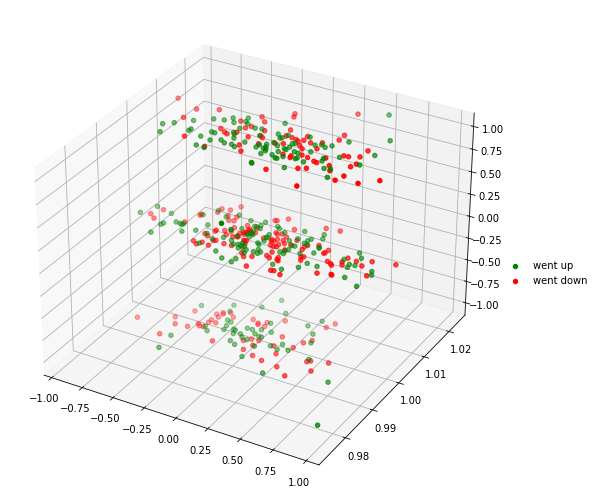

In [30]:
# %matplotlib notebook
full_test_data_X = x_wide.loc[pdidx[:, 520], :].xs(STOCK, level=1, axis=1)
test_data_Y = np.sign(DY.loc[pdidx[:, 520],STOCK])

up_y = test_data_Y[test_data_Y==1]
up_x = full_test_data_X.loc[up_y.index,:]
dwn_y = test_data_Y[test_data_Y==-1]
dwn_x = full_test_data_X.loc[dwn_y.index,:]

feat1 = 'near_price'
feat2 = 'far_price'
feat3 = 'imbalance_buy_sell_flag'

# x_d = dwn_x[feat1]
# if wap is an "average coordinate", below is a "relative coordinate"
x_d = (dwn_x['bid_price']*dwn_x['ask_size'] - dwn_x['ask_price']*dwn_x['bid_size'])/(dwn_x['bid_size']+dwn_x['ask_size'])
y_d = dwn_x[feat2]
z_d = dwn_x[feat3]

# x_nd = up_x[feat1]
x_nd = (up_x['bid_price']*up_x['ask_size'] - up_x['ask_price']*up_x['bid_size'])/(up_x['bid_size']+up_x['ask_size'])
y_nd = up_x[feat2]
z_nd = up_x[feat3]

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_nd, y_nd, z_nd, label='went up' ,color='g')#,alpha=.1)
ax.scatter(x_d, y_d, z_d, label='went down',color='r')#,alpha=.5)

ax.legend(bbox_to_anchor=(1, 0.5), loc='upper left', frameon=False)
plt.show()

In [ ]:
%matplotlib

### seems like the relative coordiante is important

In [17]:
# relative wap construction
bid_p = x_wide['bid_price']
ask_p = x_wide['ask_price']
bid_s = x_wide['bid_size']
ask_s = x_wide['ask_size']

rel_wap = (bid_p * ask_s - ask_p * bid_s) / (bid_s + ask_s)

new_cols = pd.MultiIndex.from_product([['relative_wap'], rel_wap.columns])
imbalance_df = pd.DataFrame(rel_wap.values, index=x_wide.index, columns=new_cols)

#historical target construction
target_lag_6 = y_wide.groupby(level=0).shift(6)
new_target_cols = pd.MultiIndex.from_product([['target_lag_6'], target_lag_6.columns])
target_lag_df = pd.DataFrame(target_lag_6.values, index=x_wide.index, columns=new_target_cols)


x_wide_new_feats = pd.concat([x_wide, imbalance_df, target_lag_df], axis=1)
# x_wide = x_wide.dropna(subset=[('target_lag_6', y_wide.columns[0])])


## now to create the model

In [18]:
divide = 200
train_data_X = x_wide_new_feats.loc[pdidx[:divide, :], :].xs(STOCK, level=1, axis=1).reset_index().drop(columns=['date_id'])
train_data_Y = np.sign(DY.loc[pdidx[:divide, :],STOCK]).values
valid_data_X = x_wide_new_feats.loc[pdidx[divide:, :], :].xs(STOCK, level=1, axis=1).reset_index().drop(columns=['date_id'])
valid_data_Y = np.sign(DY.loc[pdidx[divide:, :],STOCK]).values

In [19]:
mask_train = ~np.isnan(train_data_Y)
train_X_clean = train_data_X[mask_train].copy()
train_Y_clean = train_data_Y[mask_train].copy()

mask_valid = ~np.isnan(valid_data_Y)
valid_X_clean = valid_data_X[mask_valid].copy()
valid_Y_clean = valid_data_Y[mask_valid].copy()

train_Y_binary = (train_data_Y[mask_train] >= 0).astype(int)
valid_Y_binary = (valid_data_Y[mask_valid] >= 0).astype(int)

In [15]:
valid_X_clean.columns

Index(['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
       'reference_price', 'matched_size', 'far_price', 'near_price',
       'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'relative_wap',
       'target_lag_6'],
      dtype='object')

### let's try scaling the lot sizes

In [20]:
train_X_clean['bid_size'] = np.log(train_X_clean['bid_size'])
valid_X_clean['bid_size'] = np.log(valid_X_clean['bid_size'])

train_X_clean['ask_size'] = np.log(train_X_clean['ask_size'])
valid_X_clean['ask_size'] = np.log(valid_X_clean['ask_size'])

train_X_clean['matched_size'] = np.log(train_X_clean['matched_size'])
valid_X_clean['matched_size'] = np.log(valid_X_clean['matched_size'])

train_X_clean['imbalance_size'] = np.log(train_X_clean['imbalance_size'])
#replace bad values with 0
train_X_clean['imbalance_size'] = train_X_clean['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

valid_X_clean['imbalance_size'] = np.log(valid_X_clean['imbalance_size'])
#replace bad values with 0
valid_X_clean['imbalance_size'] = valid_X_clean['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

/home/travis/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log



In [21]:
BT = xgb.XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    learning_rate=0.05,
    n_estimators=20,
    max_depth=6
)

BT.set_params(eval_metric=["auc","logloss"], early_stopping_rounds=50)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=['auc', 'logloss'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [22]:
BT.fit(train_X_clean, train_Y_binary, eval_set=[(valid_X_clean, valid_Y_binary)], verbose=True)

[0]	validation_0-auc:0.61897	validation_0-logloss:0.69046
[1]	validation_0-auc:0.62263	validation_0-logloss:0.68808
[2]	validation_0-auc:0.62303	validation_0-logloss:0.68596
[3]	validation_0-auc:0.62552	validation_0-logloss:0.68391
[4]	validation_0-auc:0.62730	validation_0-logloss:0.68206
[5]	validation_0-auc:0.63028	validation_0-logloss:0.68029
[6]	validation_0-auc:0.63183	validation_0-logloss:0.67875
[7]	validation_0-auc:0.63190	validation_0-logloss:0.67750
[8]	validation_0-auc:0.63261	validation_0-logloss:0.67615
[9]	validation_0-auc:0.63313	validation_0-logloss:0.67501
[10]	validation_0-auc:0.63404	validation_0-logloss:0.67392
[11]	validation_0-auc:0.63417	validation_0-logloss:0.67299
[12]	validation_0-auc:0.63448	validation_0-logloss:0.67221
[13]	validation_0-auc:0.63473	validation_0-logloss:0.67151
[14]	validation_0-auc:0.63531	validation_0-logloss:0.67077
[15]	validation_0-auc:0.63511	validation_0-logloss:0.67020
[16]	validation_0-auc:0.63520	validation_0-logloss:0.66970
[17]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=['auc', 'logloss'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

Training Set:
AUC: 0.719113946141811
LogLoss: 0.6416983462158747
PR AUC: 0.7100862835839374
Brier  : 0.22476218311393334
----------------------------------------------------------------------------------------------------
Validation Set:
AUC: 0.6361291925882834
LogLoss: 0.6682091323862265
PR AUC: 0.619093668204853
Brier  : 0.23769483448856138
----------------------------------------------------------------------------------------------------


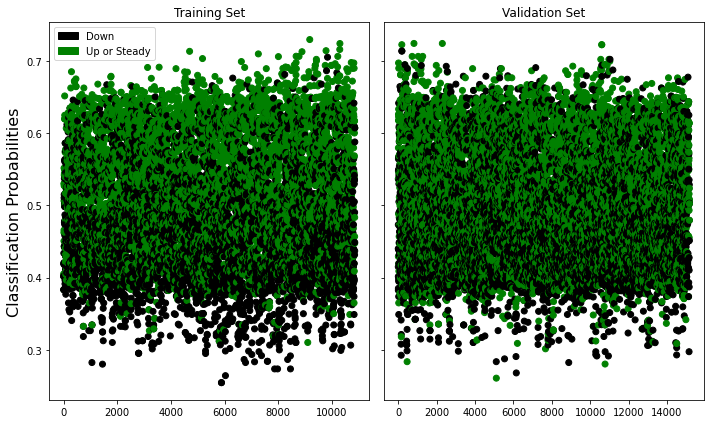

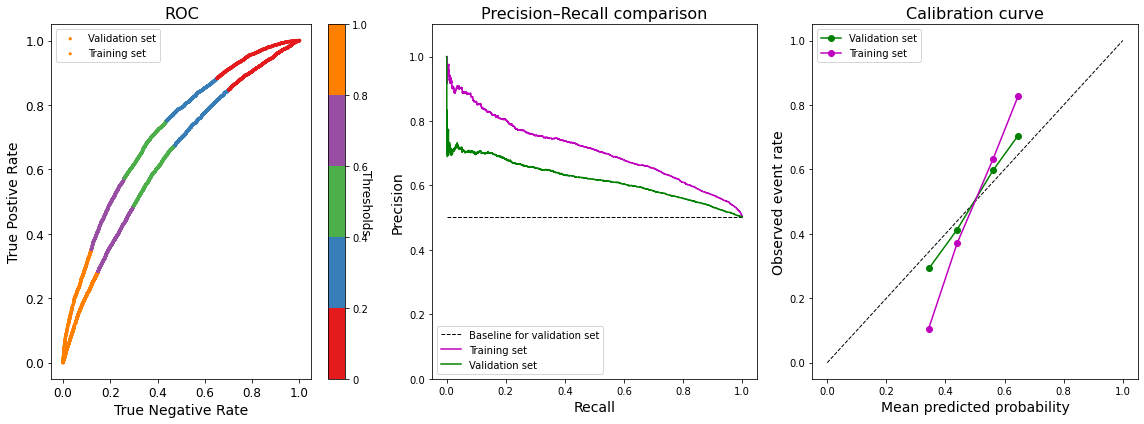

In [23]:
proba_valid_BT = BT.predict_proba(valid_X_clean)[:, 1]
proba_train_BT = BT.predict_proba(train_X_clean)[:, 1]

print("Training Set:")
print("AUC:", roc_auc_score(train_Y_binary, proba_train_BT))
print("LogLoss:", log_loss(train_Y_binary, proba_train_BT))
print("PR AUC:", average_precision_score(train_Y_binary, proba_train_BT))
print("Brier  :", brier_score_loss(train_Y_binary, proba_train_BT))
print("-----"*20)
print("Validation Set:")
print("AUC:", roc_auc_score(valid_Y_binary, proba_valid_BT))
print("LogLoss:", log_loss(valid_Y_binary, proba_valid_BT))
print("PR AUC:", average_precision_score(valid_Y_binary, proba_valid_BT))
print("Brier  :", brier_score_loss(valid_Y_binary, proba_valid_BT))
print("-----"*20)

# Classification Probabilities:
fig1, (axT,axV) = plt.subplots(1,2,figsize=(10,6), sharey=True)
fig2, (axROC,axPR,axC) = plt.subplots(1,3, figsize=(16,6))
valid_color = ['g' if y==1 else 'k' for y in valid_Y_binary]
axV.set_title("Validation Set",fontsize=12)
axV.scatter(range(len(proba_valid_BT)), proba_valid_BT, color=valid_color)

train_color = ['g' if y==1 else 'k' for y in train_Y_binary]
axT.set_ylabel("Classification Probabilities",fontsize=16)
axT.set_title("Training Set",fontsize=12)
axT.scatter(range(len(proba_train_BT)), proba_train_BT, color=train_color)

gr = mpatches.Patch(color='g', label='Up or Steady')
k = mpatches.Patch(color='k', label='Down')
axT.legend(handles=[k,gr])

# ROC:
fprV, tprV, threshV = roc_curve(valid_Y_binary,proba_valid_BT)
threshV[0] = 1
boundV = np.quantile(threshV, [0, .2, .4, .6, .8, 1.0])
norm = mcolors.BoundaryNorm(boundaries=boundV, ncolors=5, clip=True)
sc = axROC.scatter(fprV, tprV, c=threshV, cmap="Set1", norm=norm, s=5, marker='o', label='Validation set')
cb = plt.colorbar(sc, ax=axROC)
cb.set_label("Threshold bins")
cb.ax.set_yticklabels([0, .2, .4, .6, .8, 1.0])
cb.set_label('Thresholds', rotation=270,fontsize=12)

fprT, tprT, threshT = roc_curve(train_Y_binary,proba_train_BT)
threshT[0] = 1
boundT = np.quantile(threshV, [0, .2, .4, .6, .8, 1.0])
norm = mcolors.BoundaryNorm(boundaries=boundT, ncolors=5, clip=True)
sc = axROC.scatter(fprT, tprT, c=threshT, cmap="Set1", norm=norm, s=5, marker='x',label='Training set')

axROC.set_title("ROC",fontsize=16)
axROC.set_ylabel("True Postive Rate",fontsize=14)
axROC.set_xlabel("True Negative Rate",fontsize=14)
axROC.tick_params(axis='both', which='major', labelsize=12)
axROC.legend()

# Precision Recall Curve
precV, recV, thrV = precision_recall_curve(valid_Y_binary, proba_valid_BT)
precT, recT, thrT = precision_recall_curve(train_Y_binary, proba_train_BT)
pos_rate = (np.isclose(valid_Y_binary,1)).mean()
axPR.hlines(pos_rate, 0, 1, linestyles="--",color='k', linewidth=1, label="Baseline for validation set")
axPR.step(recT, precT, where="post", c='m', label='Training set')
axPR.step(recV, precV, where="post", c='g',label='Validation set')
axPR.set_xlabel("Recall",fontsize=14)
axPR.set_ylabel("Precision",fontsize=14)
axPR.set_title("Precision–Recall comparison",fontsize=16)
axPR.set_ylim((0,1.1))
axPR.legend(loc='lower left')

# Calibration Curve
prob_true, prob_pred = calibration_curve(valid_Y_binary, proba_valid_BT, n_bins=8)
prob_true_T, prob_pred_T = calibration_curve(train_Y_binary, proba_train_BT, n_bins=8)
axC.plot([0,1],[0,1],"--", lw=1,c='k')
axC.plot(prob_pred, prob_true, marker="o", c='g', label="Validation set")
axC.plot(prob_pred_T, prob_true_T, marker="o", c='m', label="Training set")
axC.set_xlabel("Mean predicted probability", fontsize=14)
axC.set_ylabel("Observed event rate", fontsize=14)
axC.set_title("Calibration curve", fontsize=16)
axC.legend()


fig1.tight_layout()
fig2.tight_layout()
plt.show()

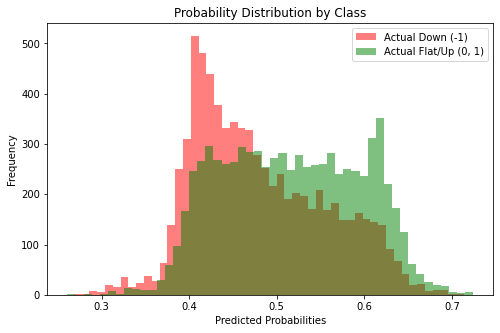

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(proba_valid_BT[valid_Y_binary == 0], bins=50, alpha=0.5, label='Actual Down (-1)', color='red')
ax.hist(proba_valid_BT[valid_Y_binary == 1], bins=50, alpha=0.5, label='Actual Flat/Up (0, 1)', color='green')

ax.set_title('Probability Distribution by Class')
ax.set_xlabel('Predicted Probabilities')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

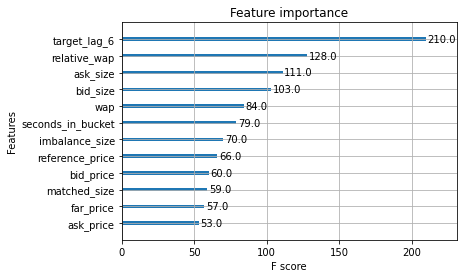

In [25]:
from xgboost import plot_importance

# 'weight' is the number of times a feature appears in a tree
plot_importance(BT, max_num_features=12, importance_type='weight')
plt.show()

In [26]:
booster = BT.get_booster()

# 2. Extract different importance types
# 'weight': number of times feature is used to split
# 'gain': average gain of splits which use the feature
# 'cover': average coverage of splits which use the feature
importance_types = ['weight', 'gain', 'cover']
importances = {t: booster.get_score(importance_type=t) for t in importance_types}

# 3. Create a clean DataFrame
importances_df = pd.DataFrame(importances).sort_values(by='gain', ascending=False)
print(importances_df)

                         weight       gain       cover
relative_wap              128.0  35.204407  729.292725
target_lag_6              210.0  12.221193  440.667633
wap                        84.0   6.297517  239.560867
reference_price            66.0   6.017755  176.167419
bid_price                  60.0   5.790616  160.206772
seconds_in_bucket          79.0   5.761032  150.409042
bid_size                  103.0   5.751620  220.543961
imbalance_buy_sell_flag    11.0   5.704741  150.576736
near_price                 52.0   5.135335  224.833664
ask_size                  111.0   5.086213  171.006195
ask_price                  53.0   5.062328  135.456482
matched_size               59.0   5.046916   99.006195
imbalance_size             70.0   4.879619  117.325752
far_price                  57.0   4.284165  107.420631


## up and down classification not looking too shabby, now let'a try predicting magnitude

In [27]:
divide = 200
train_data_X = x_wide_new_feats.loc[pdidx[divide:400, :], :].xs(STOCK, level=1, axis=1).reset_index().drop(columns=['date_id'])
train_data_Y = DY.loc[pdidx[divide:400, :],STOCK].values
valid_data_X = x_wide_new_feats.loc[pdidx[400:, :], :].xs(STOCK, level=1, axis=1).reset_index().drop(columns=['date_id'])
valid_data_Y = DY.loc[pdidx[400:, :],STOCK].values


## First, let's train and upwards/steady movement regressor

In [28]:
mask_train_up = (~np.isnan(train_data_Y)) & (train_data_Y >= 0)
train_Xup_clean = train_data_X[mask_train_up]
train_Y_up = train_data_Y[mask_train_up]

mask_valid_up = (~np.isnan(valid_data_Y)) & (valid_data_Y >= 0)
valid_Xup_clean = valid_data_X[mask_valid_up]
valid_Y_up = valid_data_Y[mask_valid_up]

### we'll also add classifier probabilities to help the regressor
Note: we train data points that the classifier was explicitly not trained on, this is important

In [29]:
train_probs = BT.predict_proba(train_Xup_clean)[:, 1]
valid_probs = BT.predict_proba(valid_Xup_clean)[:, 1]

s_train = pd.Series(train_probs, index=train_Xup_clean.index, name='clf_prob')
s_valid = pd.Series(valid_probs, index=valid_Xup_clean.index, name='clf_prob')

train_X_up = pd.concat([train_Xup_clean, s_train], axis=1)
valid_X_up = pd.concat([valid_Xup_clean, s_valid], axis=1)


### and, we'll scale the DY values in log to try and put the changes on equal footing

In [30]:
CONSTANT_BUMP = 10_000
eps = 1e-9
train_Y_up_log = np.log(CONSTANT_BUMP*train_Y_up + eps)
valid_Y_up_log = np.log(CONSTANT_BUMP*valid_Y_up + eps)

### we'll also scale the 'X_size' data with a log

In [45]:
def symlog(x):
#     if (x==0).any():
#         print('uhoh')
    return np.sign(x)*np.log(np.abs(x))

In [31]:
train_X_up['bid_size'] = np.log(train_X_up['bid_size'])
valid_X_up['bid_size'] = np.log(valid_X_up['bid_size'])

train_X_up['ask_size'] = np.log(train_X_up['ask_size'])
valid_X_up['ask_size'] = np.log(valid_X_up['ask_size'])

train_X_up['matched_size'] = np.log(train_X_up['matched_size'])
valid_X_up['matched_size'] = np.log(valid_X_up['matched_size'])

train_X_up['imbalance_size'] = np.log(train_X_up['imbalance_size'])
#replace bad values with 0
train_X_up['imbalance_size'] = train_X_up['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

valid_X_up['imbalance_size'] = np.log(valid_X_up['imbalance_size'])
#replace bad values with 0
valid_X_up['imbalance_size'] = valid_X_up['imbalance_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

# train_X_up['bid_ask_lot_spread'] = symlog(train_X_up['bid_ask_lot_spread'])
# valid_X_up['bid_ask_lot_spread'] = symlog(valid_X_up['bid_ask_lot_spread'])


/home/travis/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log



### Let's try another feature.. bid-ask-spread


In [32]:
BAspread_train = pd.Series(train_X_up['bid_size'] - train_X_up['ask_size'], index=train_X_up.index, name='bid_ask_lot_spread')
BAspread_valid = pd.Series(valid_X_up['bid_size'] - valid_X_up['ask_size'], index=valid_X_up.index, name='bid_ask_lot_spread')

train_X_up = pd.concat([train_X_up, BAspread_train], axis=1)
valid_X_up = pd.concat([valid_X_up, BAspread_valid], axis=1)


## Model:

In [33]:
RT_up = XGBRegressor(
    n_estimators=1_000,
    learning_rate=0.005,           # Ultra-slow to prevent the error jump
    max_depth=3,                   # Very shallow
    min_child_weight=100,          # Only learn very broad, obvious patterns
    objective='reg:squarederror',
    eval_metric='mae',
    base_score=0.0,
    tree_method='hist',
    early_stopping_rounds=50,
)

In [34]:
RT_up.fit(
    train_X_up, 
    train_Y_up_log,
    eval_set=[(valid_X_up, valid_Y_up_log)],
    verbose=200
)

[0]	validation_0-mae:10.46377
[200]	validation_0-mae:3.82935
[400]	validation_0-mae:1.62716
[600]	validation_0-mae:1.11594
[800]	validation_0-mae:1.01964
[999]	validation_0-mae:0.99966


XGBRegressor(base_score=0.0, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=100, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

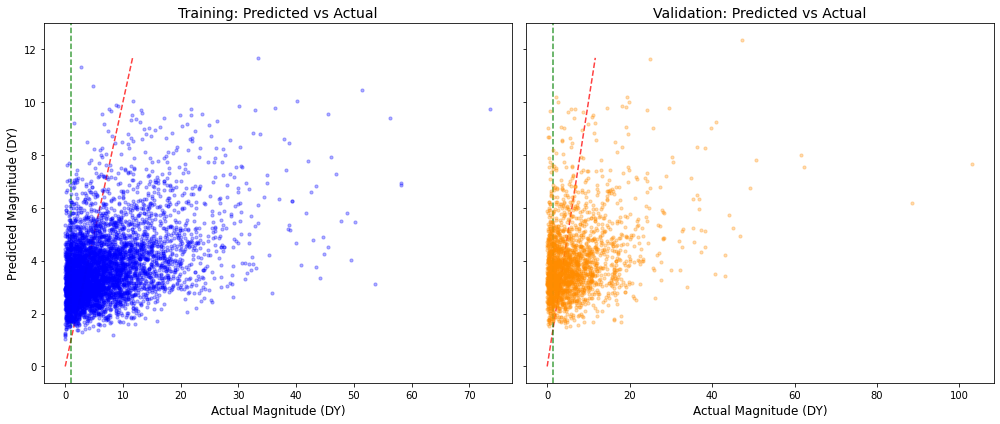

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
preds_train = (np.exp(RT_up.predict(train_X_up)) - eps)/CONSTANT_BUMP
preds_valid = (np.exp(RT_up.predict(valid_X_up)) - eps)/CONSTANT_BUMP
# --- Training Set Plot ---
ax1.scatter(train_Y_up, preds_train, alpha=0.3, color='blue', s=10)
# Add the 'Perfect Prediction' line
# lims = [0, max(train_Y_up.max(), preds_train.max())]
lims = [0, preds_train.max()]
ax1.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax1.axvline(x=preds_train.min(),linestyle='--',c='g',alpha=0.75,zorder=0)
ax1.set_title("Training: Predicted vs Actual", fontsize=14)
ax1.set_xlabel("Actual Magnitude (DY)", fontsize=12)
ax1.set_ylabel("Predicted Magnitude (DY)", fontsize=12)

# --- Validation Set Plot ---
ax2.scatter(valid_Y_up, preds_valid, alpha=0.3, color='darkorange', s=10)
ax2.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax2.axvline(x=preds_valid.min(),linestyle='--',c='g',alpha=0.75,zorder=0)
ax2.set_title("Validation: Predicted vs Actual", fontsize=14)
ax2.set_xlabel("Actual Magnitude (DY)", fontsize=12)

plt.tight_layout()

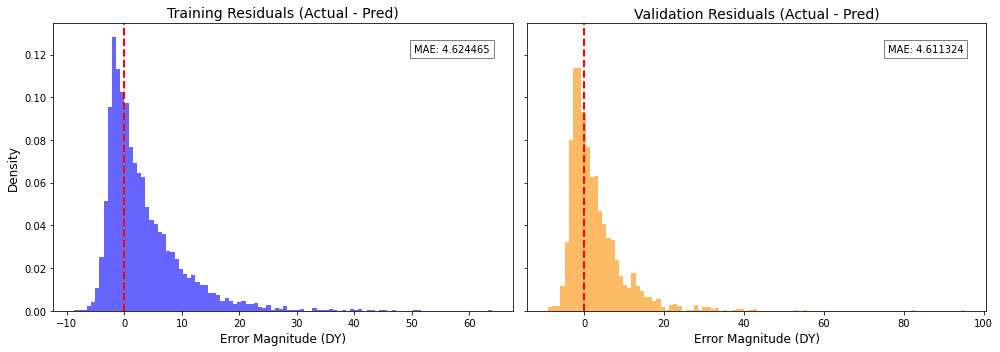

In [36]:
# 1. Calculate the Residuals (Truth - Prediction)
# Positive = Under-predicting | Negative = Over-predicting
resid_train = train_Y_up - preds_train
resid_valid = valid_Y_up - preds_valid

fig, (axH1, axH2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- Training Residuals ---
axH1.hist(resid_train, bins=100, color='blue', alpha=0.6, density=True)
axH1.axvline(0, color='red', linestyle='--', lw=2)
axH1.set_title("Training Residuals (Actual - Pred)", fontsize=14)
axH1.set_xlabel("Error Magnitude (DY)", fontsize=12)
axH1.set_ylabel("Density", fontsize=12)

# --- Validation Residuals ---
axH2.hist(resid_valid, bins=100, color='darkorange', alpha=0.6, density=True)
axH2.axvline(0, color='red', linestyle='--', lw=2)
axH2.set_title("Validation Residuals (Actual - Pred)", fontsize=14)
axH2.set_xlabel("Error Magnitude (DY)", fontsize=12)

# Optional: Add a text box with Mean Absolute Error (MAE)
train_mae = np.mean(np.abs(resid_train))
valid_mae = np.mean(np.abs(resid_valid))
axH1.text(0.95, 0.90, f'MAE: {train_mae:.6f}', transform=axH1.transAxes, ha='right', bbox=dict(facecolor='white', alpha=0.5))
axH2.text(0.95, 0.90, f'MAE: {valid_mae:.6f}', transform=axH2.transAxes, ha='right', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [37]:
# importance_type = 'gain' # Can also be 'weight' or 'cover'
# scores = RT_up.get_booster().get_score(importance_type=importance_type)

# # Sort and Plot
# sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))

# plt.figure(figsize=(10, 8))
# plt.barh(list(sorted_scores.keys())[:15], list(sorted_scores.values())[:15])
# plt.xlabel(f"XGBoost {importance_type.capitalize()}")
# plt.title(f"Top 15 Features by {importance_type.capitalize()}")
# plt.gca().invert_yaxis()
# plt.show()
booster = RT_up.get_booster()

# 2. Extract different importance types
# 'weight': number of times feature is used to split
# 'gain': average gain of splits which use the feature
# 'cover': average coverage of splits which use the feature
importance_types = ['weight', 'gain', 'cover']
importances = {t: booster.get_score(importance_type=t) for t in importance_types}

# 3. Create a clean DataFrame
importances_df = pd.DataFrame(importances).sort_values(by='gain', ascending=False)
print(importances_df)

                         weight       gain        cover
reference_price           100.0  28.942654   672.169983
imbalance_size            292.0  27.977732  2662.065186
bid_ask_lot_spread        352.0  24.975502  4102.176270
bid_size                  403.0  21.973442  3620.796631
target_lag_6              564.0  21.911959  2812.255371
ask_size                  446.0  20.768076  2763.961914
ask_price                 732.0  20.528265  3339.019043
near_price                209.0  19.596926  2153.277588
bid_price                 728.0  17.465727  3393.214355
matched_size              223.0  16.588814  2975.210693
relative_wap              207.0  15.627041  1652.053101
clf_prob                  265.0  13.930443  1822.226440
wap                        61.0  13.111118  3174.983643
imbalance_buy_sell_flag    22.0  12.422907  1681.000000
seconds_in_bucket         654.0  11.654665  2821.789062
far_price                  81.0   9.344209  1025.296265


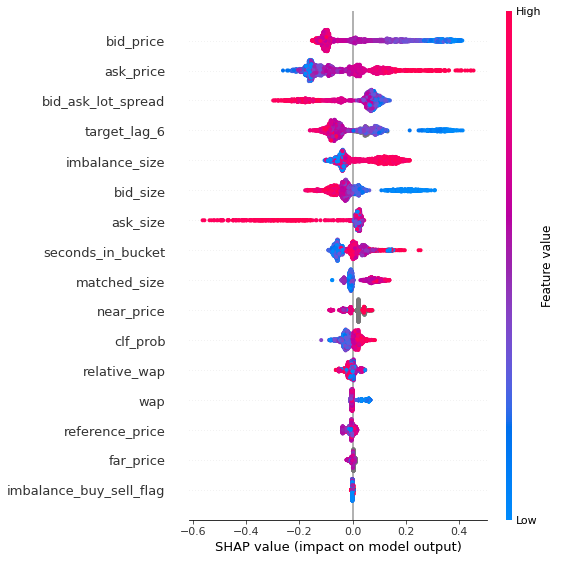

In [38]:
import shap

# Initialize the explainer
explainer = shap.TreeExplainer(RT_up)
shap_values = explainer.shap_values(valid_X_up)

# Summary plot
shap.summary_plot(shap_values, valid_X_up)

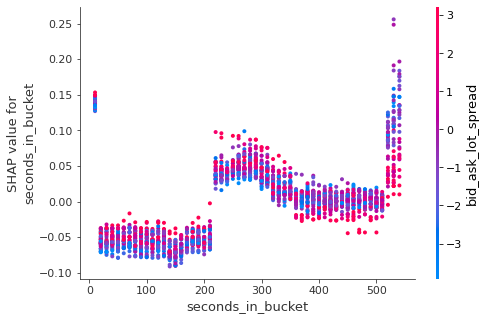

In [44]:
shap.dependence_plot("seconds_in_bucket", shap_values, valid_X_up)